In [1]:
import sys
sys.path.append("/Users/david/Documents/code/fhmm/v1")

In [2]:
import src.ads_davidjames9610.ads as ads
import src.ads_davidjames9610.useful as useful
import numpy as np
import os
import os.path
from pathlib import Path
import matplotlib.pyplot as plt
from importlib import reload


In [3]:
datasetFolder = r"/Users/david/Documents/data/speechCommands"
speech_ads = ads.AudioDatastore()
speech_ads.populate(datasetFolder,include_sub_folders=True, label_source=True)

In [4]:
unique_words = np.unique(speech_ads.labels)

dict_of_words = {}
arr_of_speakers = []
dict_of_speakers = {}

for word in unique_words:
    ads_subset = ads.subset(speech_ads, label=word)
    speakers = []
    for file in ads_subset.files:
        nm = os.path.basename(file)
        nm = nm.split('_')[0]
        speakers.append('a' + nm)
    unique_labels, unique_counts = np.unique(speakers, return_counts=True)
    filtered_labels = (unique_labels[unique_counts > 8])
    if len(filtered_labels) > 1:
        dict_of_words[word] = filtered_labels
        for label in filtered_labels:
            if label in dict_of_speakers:
                dict_of_speakers[label].append(word)
            else:
                dict_of_speakers[label] = [word]

speakers_dense = []
for key in dict_of_speakers:
    noises = dict_of_speakers[key]
    if len(noises) > 7:
        speakers_dense.append(key)

speakers = []
for file in speech_ads.files:
    nm = os.path.basename(file)
    nm = nm.split('_')[0]
    speakers.append('a' + nm)

speech_ads.set(labels=speakers)

ads_all = []
for speaker in speakers_dense:
    ads_all.append(ads.subset(speech_ads, label=speaker))


In [5]:
speakers_dense = []
for key in dict_of_speakers:
    noises = dict_of_speakers[key]
    if len(noises) > 7:
        speakers_dense.append(key)

In [6]:
speakers = []
for file in speech_ads.files:
    nm = os.path.basename(file)
    nm = nm.split('_')[0]
    speakers.append('a' + nm)

speech_ads.set(labels=speakers)

In [7]:
ads_all = []
for speaker in speakers_dense:
    ads_all.append(ads.subset(speech_ads, label=speaker))

In [8]:
# possibly updated this to include a better VAD
sr = 22050
samples = []
labels = []

labels_set = speakers_dense
num_to_label = {i: labels_set[i] for i in range(len(labels_set))}
label_to_num = {labels_set[i] : i for i in range(len(labels_set))}

count = 0
for speaker_ads in ads_all:
    count +=1
    if count % 10 == 0: print(count)
    labels.extend([label_to_num[label] for label in speaker_ads.labels]) # all the same
    samples.extend([useful.file_to_audio(file, sr)[0] for file in speaker_ads.files])

In [9]:
# import pickle
# pickle.dump({'labels': labels, 'samples': samples}, open('ubm.pickle','wb'))


In [10]:
import src.misc_davidjames9610.cross_validation as cv
from src.misc_davidjames9610.cross_validation import *
import importlib
importlib.reload(cv)

n_folds = 2
cv_output = cv.split_data_for_cross_validation(samples, labels, n_folds, test_ratio=0.1)

In [11]:
cv_index = 0    # select train and test for this iteration
importlib.reload(useful)
train = useful.SampleHolder(cv_output[TRAIN_DATA][cv_index], cv_output[TRAIN_LABEL][cv_index])
val = useful.SampleHolder(cv_output[VAL_DATA][cv_index], cv_output[VAL_LABEL][cv_index])
test = useful.SampleHolder(cv_output[TEST_DATA], cv_output[TEST_LABEL])

a2aca1e72


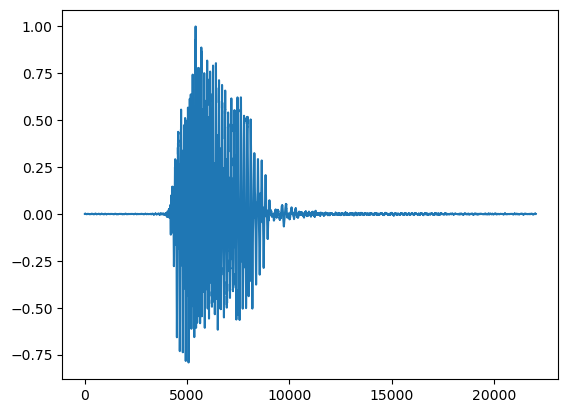

a893705bb


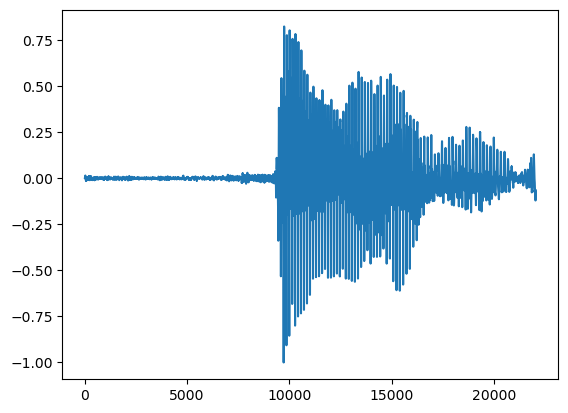

ab5cf6ea8


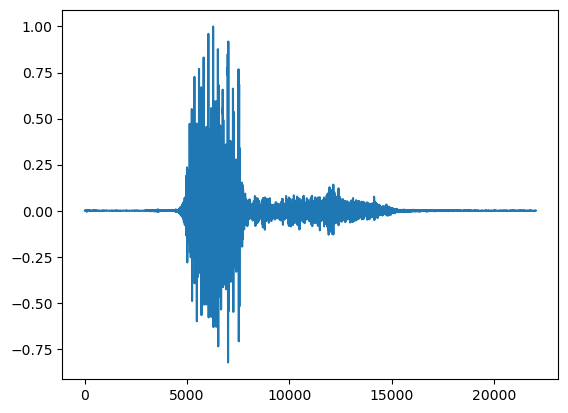

ab66f4f93


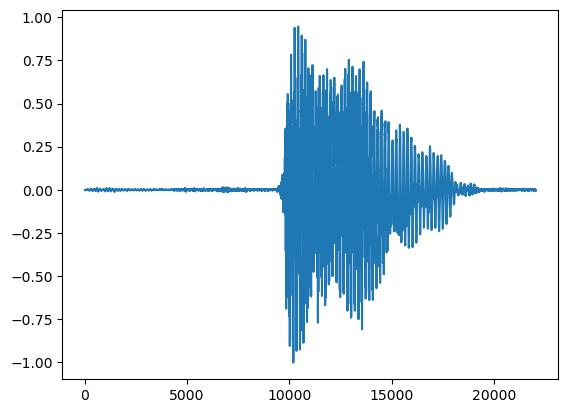

ac1d39ce8


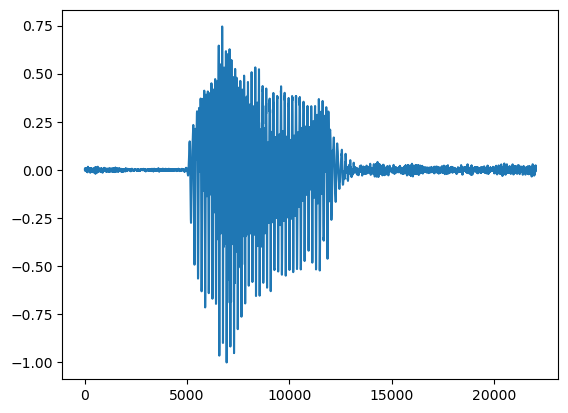

ac50f55b8


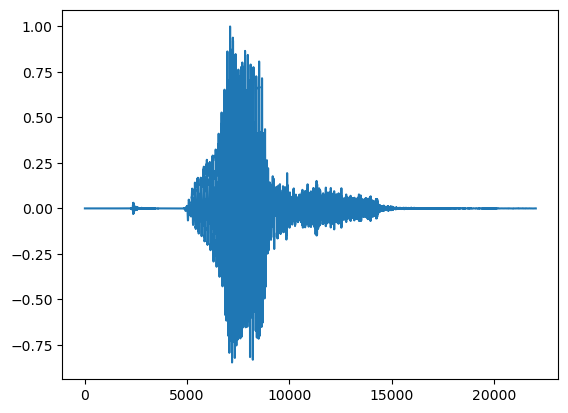

acce7416f


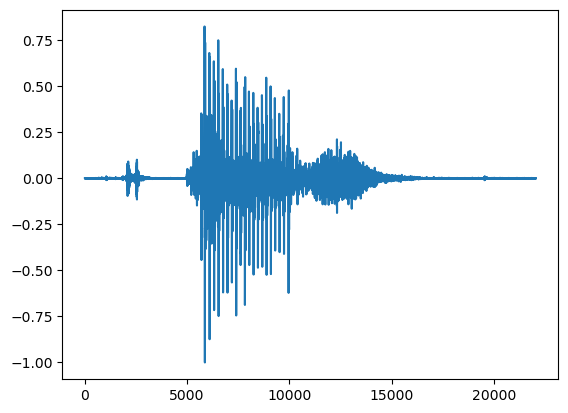

addedba85


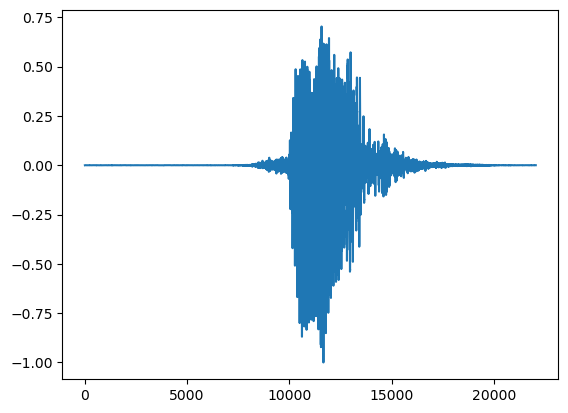

In [21]:
from IPython.display import Audio, display

for lab in labels_set:
    indices = (val.sample_labels == label_to_num[lab])
    samps = [item for item, condition in zip(val.samples, indices) if condition]
    print(lab)
    plt.plot(samps[0])
    plt.show()
    plt.close()
    display(Audio(samps[0], rate=sr))

In [12]:
from src.misc_davidjames9610 import noisey

def show_avg_powers(list_of_labels, sample_holder):
    for lab in list_of_labels:
        indices = (sample_holder.sample_labels == lab)
        samps = [item for item, condition in zip(sample_holder.samples, indices) if condition]
        avg_power = noisey.get_signal_avg_db(np.concatenate(samps))
        # avg_power_v2 = utils.get_average_power(np.concatenate(samps), use_buffer=True)
        print('label: ', lab, ' | avg power: ', avg_power) #' | v2: ',  10 * np.log10(avg_power_v2))

show_avg_powers(speakers_dense, val)

/var/folders/8g/9gktnhys29123gd2vy8kl6q40000gn/T/ipykernel_1166/2137289568.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  indices = (sample_holder.sample_labels == lab)


TypeError: 'bool' object is not iterable

In [13]:
def get_feature(samp, nfft, fs=4000):
    # add optionals here if needed
    # mfcc
    # feat = librosa.feature.mfcc(y=samp,sr=fs, n_mfcc=8, n_fft=nfft,hop_length=int(nfft/4)).T
    feat = None
    try:
        feat = useful.get_log_power_feature(samp, nfft=nfft)[2:,:]
    except:
        print('woops')
    return feat

In [14]:
# all_features = []
# nfft = 128 # 256 # 256 # 256 #128 # 256 #128
# to_remove = []
#
# for i in range(len(samples)):
#     sample = samples[i]
#     feat_b = get_feature(sample, nfft)
#     all_features.append(feat_b) #152 129

In [15]:
# np.min([len(feat) for feat in all_features])

In [16]:

# n_folds = 2
# # cv_output = cv.split_data_for_cross_validation(samples, labels, n_folds, test_ratio=0.2)
# cv_output = cv.split_data_for_cross_validation(all_features, labels, n_folds, test_ratio=0.2)

In [17]:
def normalize_features(feats, per_feature=False):
    if per_feature:
        normalised_feats = []
        for fea in feats:
            mean = np.mean(fea, axis=0)
            std_dev = np.std(fea, axis=0)
            normalised_feats.append((fea - mean) / std_dev)
        return normalised_feats
    else:
        all_features_concat = np.concatenate(feats)
        mean = np.mean(all_features_concat, axis=0)
        std_dev = np.std(all_features_concat, axis=0)
        return [((feat - mean) / std_dev) for feat in feats], {'mean': mean, 'std': std_dev}

def average_features(some_feature, avg_over, d):
    new_n = len(some_feature) // avg_over
    avg_features = np.empty((new_n, d))

    for i in range(new_n):
        start_idx = i * avg_over
        end_idx = (i + 1) * avg_over
        avg_features[i, :] = np.mean(some_feature[start_idx:end_idx, :], axis=0)
    return avg_features

def get_noise_for_sample(signal_sample, sig_db=-16, snr_1=30, snr_2=30, snr_3=30):
    noise_power_1 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_1)
    noise_power_2 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_2)
    noise_power_3 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_3)

    noisey_sample, _ = noisey.generate_gaussian_noise(len(signal_sample), noise_power_1, noise_power_2, noise_power_3)
    return noisey_sample

In [18]:
n_states = 8
inits = 1
nfft = 128
snr = 20
base_snr = 50
average_over = 1
add_noise = False
should_normalise = False
should_average = False
signal_avg_db = -17 # from inspection

In [34]:
# from final.models.fhmm import FactorialHMM
from src.misc_davidjames9610 import decode_combine as dc
from hmmlearn.hmm import GaussianHMM, GMMHMM
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
importlib.reload(dc)
importlib.reload(useful)

# simple testing
preds = {}
preds_fhmm = {}

# all_features = [get_feature(sample, nfft) for sample in samples]
# # _, mean_std_global = normalize_features(all_features)

for i in range(n_folds):
    cv_index = i
    mean_std = None
    preds[cv_index] = []
    preds_fhmm[cv_index] = []
    true_noise_features = []
    print('cv_index: ',cv_index)
    train = useful.SampleHolder(cv_output[TRAIN_DATA][cv_index], cv_output[TRAIN_LABEL][cv_index])
    val = useful.SampleHolder(cv_output[VAL_DATA][cv_index], cv_output[VAL_LABEL][cv_index])
    test = useful.SampleHolder(cv_output[TEST_DATA], cv_output[TEST_DATA])

    # train and val data
    train.features = []
    for i in range(len(train.samples)):
        feat = get_feature(train.samples[i], nfft)
        train.features.append(get_feature(train.samples[i], nfft))

    # test.features = []
    # for i in range(len(test.samples)):
    #     feat = get_feature(test.samples[i], nfft)
    #     test.features.append(get_feature(test.samples[i], nfft))

    if should_normalise: train.features, mean_std = normalize_features(train.features)
    if should_average: train.features = [average_features(feat, average_over, feat.shape[1]) for feat in train.features]

    val.features = []
    val_to_remove = []
    for i in range(len(val.samples)):
        # add noise maybe
        val_sample = val.samples[i]
        if add_noise:
            noise_sample = get_noise_for_sample(val.samples[i], signal_avg_db, snr, snr, base_snr)
            noise_feature = get_feature(noise_sample, nfft)
            if should_normalise and mean_std is not None: noise_feature = (noise_feature - mean_std['mean']) / mean_std['std']
            if should_average: noise_feature = average_features(noise_feature, average_over, noise_feature.shape[1])
            true_noise_features.append(noise_feature)
            val_sample = val_sample + noise_sample
        feat = get_feature(val_sample, nfft)
        # normalise / average
        if should_normalise and mean_std is not None: feat = (feat - mean_std['mean']) / mean_std['std']
        if should_average: feat = average_features(feat, average_over, feat.shape[1])

        # feat = average_features(feat, average_over, feat.shape[1])
        if np.isneginf(feat).any():
            val_to_remove.append(i)
        else:
            val.features.append(feat)
    for some_index in val_to_remove:
        val.remove_index(some_index)
    val.update_feature_labels()
    preds[str(cv_index) + 'true'] = np.concatenate(val.feature_labels)
    preds_fhmm[str(cv_index) + 'true'] = np.concatenate(val.feature_labels)

    # go over inits
    # TODO example using confusion matrix and combined model, should we just use this ?
    for init in range(inits):
        print('init: ', init)
        hmms = {lab: GMMHMM(n_states, n_mix=2, covariance_type='diag') for lab in labels_set}
        for lab in hmms:
            print('fitting ', lab)
            cur_hmm = hmms[lab]
            feat_indicis = train.sample_labels == label_to_num[lab]
            hmm_features = [item for item, condition in zip(train.features, feat_indicis) if condition]
            hmm_features = [array for array in hmm_features if not np.isneginf(array).any()]
            # remove inf
            cur_hmm.fit(np.concatenate(hmm_features))

        combined_model = dc.DecodeCombineGaussian([hmm for hmm in hmms.values()])
        _, val_pred, val_log_prob = combined_model.decode_hmmlearn(np.concatenate(val.features))

        preds[cv_index].append(val_pred)

        # if add_noise:
        #     noise_hmm = GaussianHMM(n_states, covariance_type='diag')
        #     noise_hmm.fit(np.concatenate(true_noise_features))
        #     fhmms = {}
        #     for key in hmms:
        #         fhmm = FactorialHMM(hmms[key], noise_hmm)
        #         fhmms[key] = fhmm.hmm
        #
        #     combined_model_fhmm = dc.DecodeCombineGaussian([fhmm for fhmm in fhmms.values()])
        #
        #     _, val_pred_fhmm, _ = combined_model_fhmm.decode_hmmlearn(np.concatenate(val.features))
        #     preds_fhmm[cv_index].append(val_pred_fhmm)


cv_index:  0


/Users/david/Documents/code/fhmm/v1/src/ads_davidjames9610/useful.py:80: RuntimeWarning: divide by zero encountered in log
  return np.log(np.square(np.abs(librosa.stft(sample, n_fft=nfft)).T))


init:  0
fitting  a2aca1e72
fitting  a893705bb
fitting  ab5cf6ea8
fitting  ab66f4f93
fitting  ac1d39ce8
fitting  ac50f55b8
fitting  acce7416f
fitting  addedba85


ValueError: 'full' covars must have shape (n_components, n_dim, n_dim)

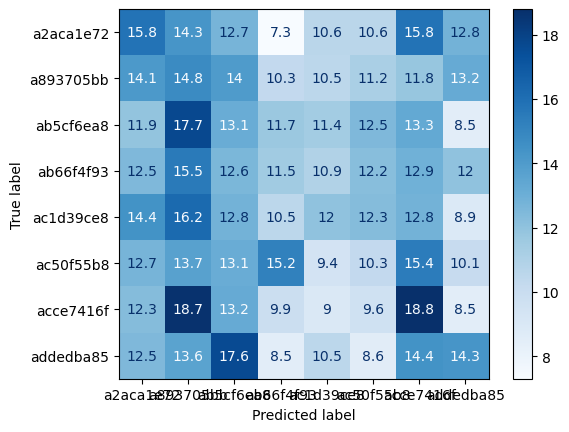

In [32]:
cms = []
for i in range(n_folds):
    pred_cv = preds[i]
    true_cv = preds[str(i) + 'true']
    for pred in pred_cv:
        cm = confusion_matrix(true_cv, pred, labels=[0,1,2,3,4,5,6,7], normalize='true')
        cms.append(cm)
avg_cm = useful.get_average_cm(cms)
avg_cm = np.round(avg_cm * 1000) / 10
disp = ConfusionMatrixDisplay(confusion_matrix=avg_cm,display_labels=labels_set)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

In [31]:
hmms['a2aca1e72'].score(val.features[5])

# some_hmm = GaussianHMM(2)
# some_hmm.score()

-90618.11744926838